## Getting data by area and fitting Random forest model

The present notebook:

   - loads the data provided by the user selected by area.
   - merges it with E.coli data
   - trains a Random Forest model after grid search of hyperparameters
   - Visualizes results in interactive plotly image

In [1]:
from ews.models import BathingSpot
from django_pandas.io import read_frame
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from shapely.geometry import shape, Point
import plotly.express as px
import statsmodels


In [2]:
model = PredictionModel.objects.get(name = "Random Forest model")

In [3]:
PredictionModel.objects.all()

<QuerySet [<PredictionModel: testmodel>, <PredictionModel: Random Forest model>, <PredictionModel: Random Forest Marne>, <PredictionModel: Model Pont d'Iena>, <PredictionModel: Pont d'iena_rg (rain/flow)>, <PredictionModel: Chenneviere_model1>, <PredictionModel: Rainarea II Model>]>

In [4]:
PredictionModel.objects.all()

<QuerySet [<PredictionModel: testmodel>, <PredictionModel: Random Forest model>, <PredictionModel: Random Forest Marne>, <PredictionModel: Model Pont d'Iena>, <PredictionModel: Pont d'iena_rg (rain/flow)>, <PredictionModel: Chenneviere_model1>, <PredictionModel: Rainarea II Model>]>

In [5]:
areas = read_frame(model.area.all())

In [6]:
areavars = []
for index1, row1 in areas.iterrows():
    df = read_frame(Site.objects.filter(feature_type = FeatureType.objects.get(name=row1["feature_type"])))
    polygon = shape(row1["geom"])
    select = []
    
    for index2, row2 in df.iterrows():
        select.append(polygon.contains(shape(row2['geom'])))
    data = read_frame(FeatureData.objects.filter(site__in = df[select]['id']), index_col = "date")
    data["area"] = row1["name"]
    data["feature_type"] = row1["feature_type"]
    areavars.append(data)

In [7]:
lagvars = []

for i in range(len(areavars)):
    ft = areavars[i].area.unique()
    d = areavars[i].pivot(columns = 'site', values = 'value')
    if len(d.columns) > 1:
        d = pd.DataFrame(d.mean(axis = 1, skipna = True))
    for j in [1, 2, 3, 4, 5]:
        df = pd.DataFrame()
        df[ft + '_shift_'+ str(j)] = d.rolling(window=j).mean().shift(1)
        lagvars.append(df)
        
res = pd.concat(lagvars, axis = 1)

<AxesSubplot:xlabel='date'>

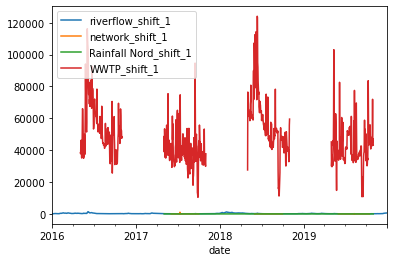

In [8]:
res.filter(regex='_shift_1').plot()

In [9]:
res = res[res.index.month.isin([ 6, 7, 8, 9])].reset_index()

In [10]:
FIB = read_frame(FeatureData.objects.filter(site = model.site.all()[0]))

In [27]:
FIB["date"] = FIB.date.round("D")

In [29]:
d = FIB.merge(res, on= "date").drop("variable", axis = 1)

In [32]:
D = d.dropna()

In [33]:
#D = D[D["value"]<5000]

In [34]:
y = np.log10(D["value"])

In [37]:
X = D.drop(["date", "value", "id", "site"], axis = 1)

In [19]:
X = X.apply(pd.to_numeric, downcast='float')

In [20]:
y = y.apply(pd.to_numeric, downcast='float')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [156]:
grid = {'n_estimators':[1000], 'max_depth': np.linspace(1, 6, 6), 'max_features': [2, 4, 6],  'min_samples_leaf':[1]} 


In [83]:
import numpy as np
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return diff

# score will negate the return value of my_custom_loss_func,
# which will be np.log(2), 0.693, given the values for X
# and y defined below.
score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [84]:

from sklearn.model_selection import GridSearchCV, train_test_split


# Instantiate the ElasticNet regressor: elastic_net
rf = RandomForestRegressor()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(rf, param_grid=grid,  cv = 5)

# Fit it to the training data

gm_cv.fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators = gm_cv.best_params_["n_estimators"],
                           max_depth = gm_cv.best_params_["max_depth"],
                           max_features = gm_cv.best_params_["max_features"])
rf.fit(X_train, y_train)


# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
y_pred1 = rf.predict(X_test)


r2 = gm_cv.score(X_test, y_test)
r2_in = gm_cv.score(X_train, y_train)

mse = mean_squared_error(y_test, y_pred)
mse_in = mean_squared_error(y_train, gm_cv.predict(X_train))

print(str("OUT OF SAMPLE METRICS:"))
print("Tuned  RandomForest R squared: {}".format(r2))
print("Tuned RandomForestt MSE: {}".format(mse))
print('---------------------------')
print("IN SAMPLE METRICS:")
print("Tuned  RandomForest R squared: {}".format(r2_in))
print("Tuned RandomForestt MSE: {}".format(mse_in))



OUT OF SAMPLE METRICS:
Tuned  RandomForest R squared: 0.30645237402144687
Tuned RandomForestt MSE: 0.08584785595374084
---------------------------
IN SAMPLE METRICS:
Tuned  RandomForest R squared: 0.6516211535398994
Tuned RandomForestt MSE: 0.04982963673662809


In [157]:
rf = RandomForestRegressor(n_estimators = 1000, min_samples_leaf = 1)

In [158]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [159]:
rf.score(X_train, y_train)

0.8920816164146215

In [160]:
rf.score(X_test, y_test)

0.5001752864084181

In [161]:
pred = rf.predict(X_test)

In [162]:
mean_squared_error(pred, y_test)

0.2309557393976111

In [163]:
preds = []
for i in range(1000):
    preds.append(rf.estimators_[i].predict(X_test))

el_arrays = []
for j in range(len(y_test)):
    el_arrays.append([item[j] for item in preds])

In [164]:
lower = []
upper = []
for i in range(len(el_arrays)):
    lower.append(np.percentile(el_arrays[i], 5))
    upper.append(np.percentile(el_arrays[i], 95))

In [165]:
np.log10(500)

2.6989700043360187

In [166]:
df = pd.DataFrame({"y_test":y_test, "mean":pred, "P95": upper, "P5": lower})

In [167]:
comparison_column = np.where(df["y_test"] < df["P5"], True, False)

In [168]:
df["sample_number"] = np.linspace(1, len(y_test), len(y_test))

In [169]:
df = df.melt(id_vars=['sample_number'], value_vars=['y_test', 'P5', 'mean', 'P95'])

In [170]:
fig = px.scatter(df, x = "sample_number", y = "value", color = "variable", 
           color_discrete_sequence=['#212c52','light grey', '#75c3ff','light grey'])
fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "ground truth and predicted",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)

In [171]:
px.histogram(x = y_test-pred)

In [172]:
np.sqrt(np.mean((y_test-pred)**2))

0.48057854654323795

In [173]:
np.std(y_test-pred)

0.4702919222340426

In [175]:
df_test = pd.DataFrame({'meas': y_test, 'pred': rf.predict(X_test), 'split': 'out of sample'})
df_train = pd.DataFrame({'meas': y_train, 'pred': rf.predict(X_train), 'split': 'in sample'})
df = pd.concat([df_test, df_train])
                        


In [176]:
fig = px.scatter(df, x = "meas", y = "pred", color = "split", 
                 color_discrete_sequence=['#212c52','#75c3ff'])

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)

#['#75c3ff', "red"],#, marker_line_color='#212c52',
 #                 marker_line_width=1.5, opacity=1)



In [177]:
fig.show()

In [178]:
importances = pd.Series(data=rf.feature_importances_,
                        index= X.columns)

# Sort importances
importances_sorted = importances.sort_values()
importances_df = importances_sorted.reset_index()
importances_df.columns = ["feature", "importance"]

In [179]:
# Draw a horizontal barplot of importances_sorted
import plotly.express as px


fig = px.bar(importances_df, y="feature", x="importance", orientation='h'    )

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Feature importance of Random Forest model'}
    #markercolor = "#212c52"
  
)
fig.update_traces(marker_color='#75c3ff', marker_line_color='#75c3ff',
                  marker_line_width=1.5, opacity=1)

fig.show()


# AdaBoost

In [180]:
from sklearn.ensemble import AdaBoostRegressor

In [181]:
ada = AdaBoostRegressor(n_estimators=10000)

In [182]:
ada.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=10000)

In [183]:
ada.score(X_train, y_train)

0.635868278163646

In [184]:
y_pred = ada.predict(X_test)

In [185]:
ada.score(X_test, y_test)

0.43882017658246864

In [188]:
fig = px.scatter(x = y_test, y = y_pred)

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)

In [189]:
fig.show()

## Calculating prediction intervals

In [191]:
from sklearn.ensemble import GradientBoostingRegressor# Set lower and upper quantile

LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95# Each model has to be separate

lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")

upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [192]:
import scipy.stats
import decimal

weights = scipy.stats.norm(2, 1).pdf(y_train.apply(float))

In [193]:
px.scatter(x = y_train, y = weights)

In [194]:
# Fit models
lower_model.fit(X_train, y_train, sample_weight =weights)
mid_model.fit(X_train, y_train, sample_weight =weights)
upper_model.fit(X_train, y_train, sample_weight =weights)# Record actual values on test set

predictions = pd.DataFrame(y_test)# Predict

predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [195]:
predictions["Nummer"] = range(len(predictions))

In [196]:
import plotly.graph_objects as go

upper_bound = go.Scatter(name="Oberes Vorhersageintervall",
x= predictions["Nummer"],
y=predictions["upper"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"),
fillcolor="rgba(68, 68, 68, 1)")#, fill="tonexty")

mean = go.Scatter(name="Vorhergesagter Mittelwert",
x= predictions["Nummer"],
y=predictions["mid"],
marker = dict(color = "rgb(0, 86, 110)"),
mode="lines",
line=dict(width=2, color= "rgb(0, 86, 110)"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")

measurements = go.Scatter(name="Vorhergesagter Mittelwert",
x= predictions["Nummer"],
y=predictions["value"],
marker = dict(color = "orange", size = 8, opacity = .8),
mode="markers",
line=dict(width=2, color= "red"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")



lower_bound = go.Scatter(name="Unteres Vorhersageintervall",
x= predictions["Nummer"],
y=predictions["lower"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"))

data = [lower_bound, mean, upper_bound, measurements]

layout=go.Layout(title='Vorhergesagte E.coli Konzentration seit Beginn der Badesaison 2020',
yaxis=dict(title="E.coli lg [MPN/100ML), showlegend = True"))

fig=go.Figure(data=data, layout = layout)
#fig.update_layout(legend=dict(
#    yanchor="top",
#    title=None,
#    y=0.99,
#    xanchor="left",
#    x=0.01
#))

fig.show()
    

In [198]:
fig = px.scatter(predictions, x = "value", y = "mid", 
                 color_discrete_sequence=['#212c52'], trendline = 'OLS')

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)#['#75c3ff', "red"],#, marker_line_color='#212c52',
 #                 marker_line_width=1.5, opacity=1)

fig.show()

In [200]:


import numpy as np
import pandas as pd
from sklearn.datasets import make_regression

from matplotlib import pyplot as plt
%matplotlib inline

from bartpy.sklearnmodel import SklearnModel



In [202]:
def get_clean_model():
    return SklearnModel(n_chains=4, 
                        n_jobs= 4, 
                        n_burn=200,
                        n_samples=1000, 
                        n_trees=200, 
                        initializer=None)



In [203]:
model = get_clean_model()



In [204]:
bart = model.fit(X_train, y_train)

In [205]:
fig = px.scatter(y = bart.predict(X_test), x = y_test, 
           color_discrete_sequence=['#212c52','light grey', '#75c3ff','light grey'])
fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "ground truth and predicted",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)

In [206]:
predicitons = bart.predict(X_test)

In [207]:
dir(bart)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_acceptance_trace',
 '_check_n_features',
 '_combine_chains',
 '_construct_model',
 '_convert_covariates_to_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_model_samples',
 '_more_tags',
 '_out_of_sample_predict',
 '_prediction_samples',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'acceptance_trace',
 'alpha',
 'beta',
 'columns',
 'combined_chains',
 'data',
 'extract',
 'f_chains',
 'f_delayed_chains',
 'fit',
 'fit_predict',
 'from_extract',
 'get_params',
 'initializer',
 'l2_error',
 'model',
 'model_samples',
 'n_burn',
 'n_chains

NameError: name 'bart' is not defined